In [1]:
import numpy as np
import sys
import xarray as xr
from scipy.io import netcdf
import matplotlib.pyplot as plt
import cftime


In [2]:
def monthly_to_annual(array):
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

In [3]:
exps_list = ('ssp585','ssp534-over')
vars_list = ('tas','fgco2','nbp')
gridvars_list = ('areacella','areacello','sftlf','sftof')

models_list = ('CanESM5','UVic', 'CESM2-WACCM', 'IPSL-CM6A-LR')

globally_gridded = [True, False, True, True]

nmodels = len(models_list)
nvars = len(vars_list)
nexps = len(exps_list)
ngridvars = len(gridvars_list)


file_master_list_dynamics = [[[[] for i in range(nexps )] for j in range(nvars)] for k in range(nmodels)]
### index this file as [model_i][var_i][exp_i]

file_master_list_grids = [[[] for j in range(ngridvars)] for k in range(nmodels)]
### index this file as [model_i][gridvar_i]

time_offset = [0,25]
nyears_total = 2300-2015+1


In [4]:
### load all the files for CanESM5

model_i = models_list.index('CanESM5')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2015-2100.nc',
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2101-2180.nc',
'fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc',
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc',
'nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'tas_Amon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2040-2100.nc',
'fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc'
]

file_master_list_grids[model_i] = [
'areacella_fx_CanESM5_ssp585_r1i1p1f1_gn.nc',
'areacello_Ofx_CanESM5_ssp585_r1i1p1f1_gn.nc',
'sftlf_fx_CanESM5_ssp585_r1i1p1f1_gn.nc',
'sftof_Ofx_CanESM5_ssp585_r1i1p1f1_gn.nc'
]

In [5]:
### load all the files for CESM2-WACCM

model_i = models_list.index('CESM2-WACCM')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_210101-215012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc',
'nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-208912.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_209001-210012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'tas_Amon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_204001-210012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_210101-215012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc',
'nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc'
]

file_master_list_grids[model_i] = [
'areacella_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc',
'areacello_Ofx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc',
'sftlf_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc',
'sftof_Ofx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc'
]

In [6]:
### load all the files for IPSL-CM6A-LR

model_i = models_list.index('IPSL-CM6A-LR')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = [
'tas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
'tas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = [
'fgco2_Oyr_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn_2015-2100.nc',
'fgco2_Oyr_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = [
'nbp_Lmon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_201501-210012.nc',
'nbp_Lmon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = [
'tas_Amon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_204001-210012.nc',
'tas_Amon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = [
'fgco2_Oyr_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gn_2040-2100.nc',
'fgco2_Oyr_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gn_2101-2300.nc'
]

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = [
'nbp_Lmon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_204001-210012.nc',
'nbp_Lmon_IPSL-CM6A-LR_ssp534-over_r1i1p1f1_gr_210101-230012.nc'
]

file_master_list_grids[model_i] = [
'areacella_fx_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr.nc',
'areacello_Ofx_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn.nc',
'sftlf_fx_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr.nc',
None
]


In [7]:
### load all the files for UVic

model_i = models_list.index('UVic')

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp585')] = 'tsi_585_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp585')] = 'tsi_585_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp585')] = 'tsi_585_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('ssp534-over')] = 'tsi_534OS_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('ssp534-over')] = 'tsi_534OS_c3.nc'

file_master_list_dynamics[model_i][vars_list.index('nbp')][exps_list.index('ssp534-over')] = 'tsi_534OS_c3.nc'

## The lack of a grid here is going to be used to indicate that the data is already 
## globally integrated.
file_master_list_grids[model_i] = [
None
]

In [8]:
### load the terrestrial NBP flux
i_var = vars_list.index('nbp')
nbp_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
zonal_mean_anual_nbp_list = []
for model_i in range(nmodels):
    zonal_mean_anual_nbp_list.append([])
    print(models_list[model_i])
    #
    if globally_gridded[model_i]:
        # load landmask and land areas
        areavar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacella')])['areacella']
        sftlfvar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftlf')])['sftlf']
    #
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            nbpvar = dataset['nbp']
            nbpvar.data = (np.ma.masked_invalid(nbpvar.data))
            global_nbp = (nbpvar * sftlfvar.data/100. * areavar.data).sum(dim="lat").sum(dim="lon").compute() * 86400. * 365. * 1e3 * 1e-15
            global_nbp_annual = monthly_to_annual(global_nbp)
            nbp_trajectories[model_i,exp_i,time_offset[exp_i]:time_offset[exp_i]+len(global_nbp_annual)] = global_nbp_annual.rolling(time=7).mean().values
            zonal_mean_anual_nbp = monthly_to_annual(nbpvar).mean(dim="lon").compute()
            zonal_mean_anual_nbp_list[model_i].append(zonal_mean_anual_nbp)
        else:
            dataset = xr.open_dataset(file_master_list_dynamics[model_i][i_var][exp_i], decode_times=False)
            global_nbp_annual = dataset['F_carba2l']
            nbp_trajectories[model_i,exp_i,time_offset[exp_i]:] = global_nbp_annual[time_offset[exp_i]:nyears_total].rolling(time=7).mean()
            zonal_mean_anual_nbp_list[model_i].append(None)

CanESM5
UVic
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'nbp' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable

IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 obj

In [9]:
years = np.arange(nyears_total)+2015.



In [10]:
### load the ocean fgco2 flux
i_var = vars_list.index('fgco2')
fgco2_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
for model_i in range(nmodels):
    print(models_list[model_i])
    #
    if(globally_gridded[model_i]):
        # load landmask and land areas
        area_ocean_var = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacello')])['areacello']
        if file_master_list_grids[model_i][gridvars_list.index('sftof')] != None:
            sftofvar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('sftof')])['sftof']
        else:
            sftofvar = xr.DataArray([100.])
    #
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            fgco2var = dataset['fgco2']
            if models_list[model_i] == 'CESM2-WACCM':
                fgco2var = monthly_to_annual(fgco2var)
            global_fgco2_annual = (fgco2var * sftofvar.data/100. * area_ocean_var.data).sum(dim=fgco2var.dims[1]).sum(dim=fgco2var.dims[2]) * 86400. * 365. * 1e3 * 1e-15
            fgco2_trajectories[model_i,exp_i,time_offset[exp_i]:time_offset[exp_i]+len(global_fgco2_annual)] = global_fgco2_annual.rolling(time=7).mean()
        else:
            dataset = xr.open_dataset(file_master_list_dynamics[model_i][i_var][exp_i], decode_times=False)
            global_fgco2_annual = dataset['F_carba2o']
            fgco2_trajectories[model_i,exp_i,time_offset[exp_i]:] = global_fgco2_annual[time_offset[exp_i]:nyears_total].rolling(time=7).mean()

CanESM5
UVic
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'sftof' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/cdkoven/miniconda2/envs/py3/lib/p

In [11]:
## load the global mean surface air temperature
i_var = vars_list.index('tas')
tas_trajectories = np.ma.masked_all([nmodels,nexps,nyears_total])
for model_i in range(nmodels):
    print(models_list[model_i])
    #
    if(globally_gridded[model_i]):
        # load gridcell areas
        areavar = xr.open_dataset(file_master_list_grids[model_i][gridvars_list.index('areacella')])['areacella']
    #
    for exp_i in range(nexps):
        if globally_gridded[model_i]:
            dataset = xr.open_mfdataset(file_master_list_dynamics[model_i][i_var][exp_i])
            tasvar = dataset['tas']
            global_tas_annual = (monthly_to_annual(tasvar)  * areavar.data).sum(dim="lat").sum(dim="lon").compute() / areavar.sum(dim="lat").sum(dim="lon")
            tas_trajectories[model_i,exp_i,time_offset[exp_i]:time_offset[exp_i]+len(global_tas_annual)] = global_tas_annual.rolling(time=7).mean() - 273.15
        else:
            dataset = xr.open_dataset(file_master_list_dynamics[model_i][i_var][exp_i], decode_times=False)
            global_tas_annual = dataset['A_sat']
            tas_trajectories[model_i,exp_i,time_offset[exp_i]:] = global_tas_annual[time_offset[exp_i]:nyears_total].rolling(time=7).mean()

CanESM5
UVic
CESM2-WACCM


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


IPSL-CM6A-LR


/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/cdkoven/miniconda2/envs/py3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/Users/cdkoven/miniconda2/envs/py3/lib/p

In [12]:
ssp534os_color = [154./256., 109./256., 201./256.]
ssp585_color = [132./256., 11./256., 34./256.]

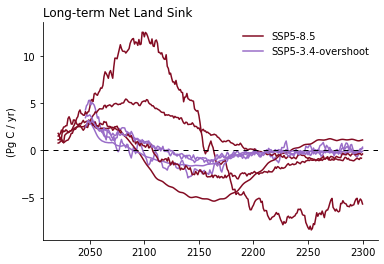

In [13]:
ax = plt.subplot(111)

for model_i in range(nmodels):
    ax.plot(years, nbp_trajectories[model_i,0,:], color=ssp585_color)
    ax.plot(years, nbp_trajectories[model_i,1,:], color=ssp534os_color)
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

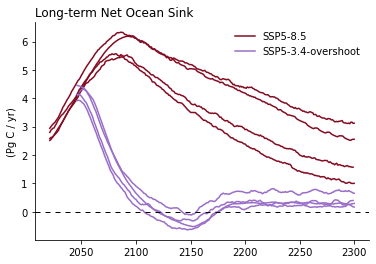

In [14]:
ax = plt.subplot(111)

for model_i in range(nmodels):
    ax.plot(years, fgco2_trajectories[model_i,0,:], color=ssp585_color)
    ax.plot(years, fgco2_trajectories[model_i,1,:], color=ssp534os_color)
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

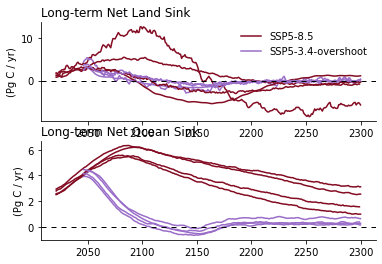

In [15]:
ax = plt.subplot(211)

for model_i in range(nmodels):
    ax.plot(years, nbp_trajectories[model_i,0,:], color=ssp585_color)
    ax.plot(years, nbp_trajectories[model_i,1,:], color=ssp534os_color)
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Land Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

ax = plt.subplot(212)

for model_i in range(nmodels):
    ax.plot(years, fgco2_trajectories[model_i,0,:], color=ssp585_color)
    ax.plot(years, fgco2_trajectories[model_i,1,:], color=ssp534os_color)
    
ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('(Pg C / yr)')
plt.title('Long-term Net Ocean Sink',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

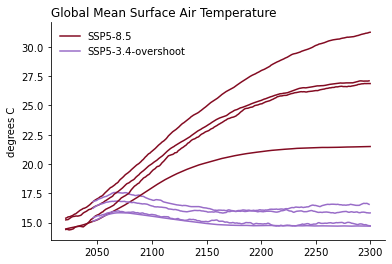

In [16]:
ax = plt.subplot(111)

for model_i in range(nmodels):
    ax.plot(years, tas_trajectories[model_i,0,:], color=ssp585_color)
    ax.plot(years, tas_trajectories[model_i,1,:], color=ssp534os_color)
    
#ax.axhline(y=0, dashes=[5,5], color='black', linewidth=1.)
plt.ylabel('degrees C')
plt.title('Global Mean Surface Air Temperature',loc='left')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(['SSP5-8.5', 'SSP5-3.4-overshoot'], frameon=False)

3


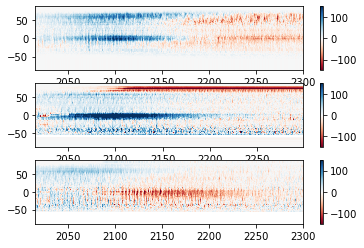

In [17]:
### plot zonal-mean fields of NBP over time
max_val = 150 #saturating color in g C / m2 / yr
n_gridded = 0
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        n_gridded = n_gridded+1
print(n_gridded)
fig, axs = plt.subplots(n_gridded)
idx = -1
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_nbp_list[model_i][0].time))+2015, zonal_mean_anual_nbp_list[model_i][0].lat, zonal_mean_anual_nbp_list[model_i][0].transpose()*86400.*365.*1e3, rasterized=True, vmin=-max_val, vmax=max_val, cmap='RdBu')
        fig.colorbar(c, ax=axs[idx])

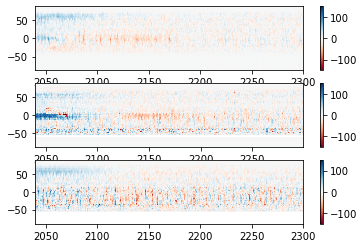

In [18]:
fig, axs = plt.subplots(n_gridded)
idx = -1
for model_i in range(nmodels):
    if globally_gridded[model_i]:
        idx = idx+1
        c = axs[idx].pcolormesh(np.arange(len(zonal_mean_anual_nbp_list[model_i][1].time))+2040, zonal_mean_anual_nbp_list[model_i][1].lat, zonal_mean_anual_nbp_list[model_i][1].transpose()*86400.*365.*1e3, rasterized=True, vmin=-max_val, vmax=max_val, cmap='RdBu')
        fig.colorbar(c, ax=axs[idx])


### below is code to search the ESG and see what variables exist for the 21st and 22nd centuries

In [19]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        ##cdk print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [20]:
century_strings = ['-22', '-23']

In [21]:
ssp585_nbp_files = esgf_search(variable_id='nbp', experiment_id='ssp585')
for url in ssp585_nbp_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Lmon/nbp/gn/v20190429/nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Lmon/nbp/gn/v20190429/nbp_Lmon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Lmon/nbp/gn/v20200702/nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Lmon/nbp/gn/v20200702/nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Lmon/nbp/gn/v20200702/nbp_Lmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_225101-229912.nc
http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r1

In [22]:
ssp534os_nbp_files = esgf_search(variable_id='nbp', experiment_id='ssp534-over')
for url in ssp534os_nbp_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20190306/nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20190429/nbp_Lmon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20200701/nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20200701/nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_220101-225012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Lmon/nbp/gn/v20200701/nbp_Lmon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_225101-229912.nc
http://esgf-data1.llnl.gov/thredds/dodsC/css03_

In [23]:
ssp534os_fgco2_files = esgf_search(variable_id='fgco2', experiment_id='ssp534-over')
for url in ssp534os_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Omon/fgco2/gn/v20190306/fgco2_Omon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2101-2300.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Omon/fgco2/gn/v20190429/fgco2_Omon_CanESM5_ssp534-over_r1i1p1f1_gn_210101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp534-over/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp534-over_r1i1p1f1_gn_2101-2300.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Omon/fgco2/gn/v20200701/fgco2_Omon_CESM2-WACCM_ssp534-over_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroo

In [24]:
ssp585_fgco2_files = esgf_search(variable_id='fgco2', experiment_id='ssp585')
for url in ssp585_fgco2_files:
    found = False
    for substring in century_strings:
        if url.find(substring) != -1:
            found = True
    if found:
        print(url)

http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Omon/fgco2/gn/v20190429/fgco2_Omon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc
http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esgD_dataroot/AR6/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p1f1/Oyr/fgco2/gn/v20190429/fgco2_Oyr_CanESM5_ssp585_r1i1p1f1_gn_2181-2300.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Omon/fgco2/gn/v20200702/fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_215101-220012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Omon/fgco2/gn/v20200702/fgco2_Omon_CESM2-WACCM_ssp585_r1i1p1f1_gn_220101-225012.nc
http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/